In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs, merge_models
from ggmodel_dev.validation import score_model, plot_diagnostic

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

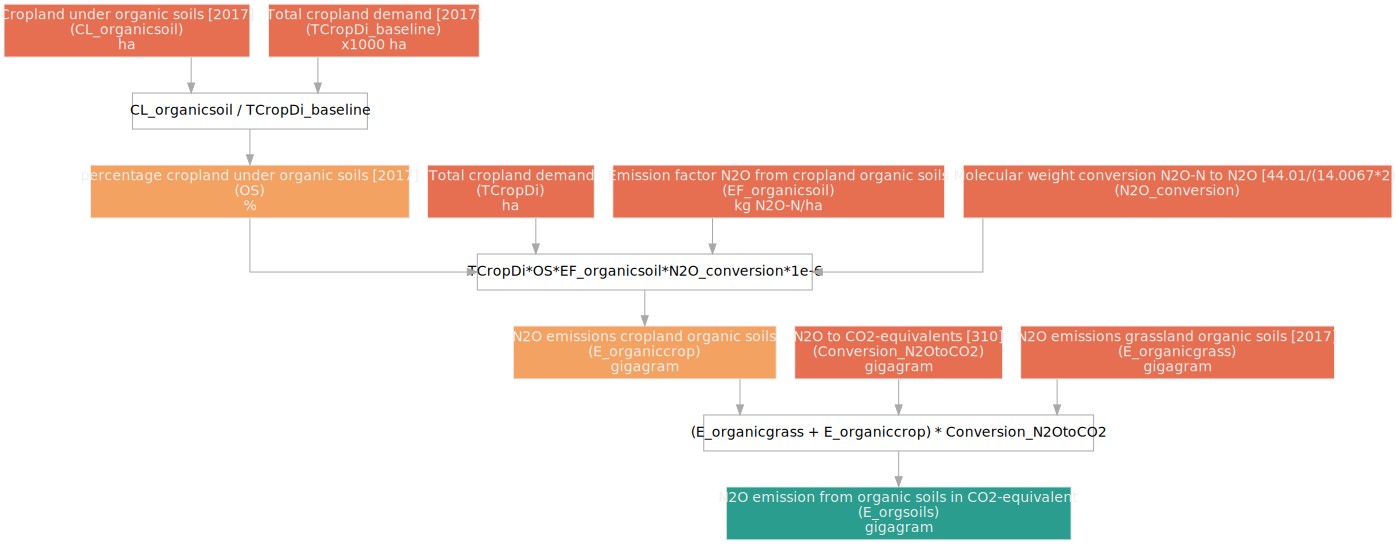

In [3]:
#CO2eq emissions from the cultivation of organic soils
#dataset cultivation of organic soils: http://www.fao.org/faostat/en/#data/GV 

Emissions_organic_soils = {
    
    'CL_organicsoil': {'type': 'input',
             'unit': 'ha',
             'name': 'Cropland under organic soils [2017]'},
    'TCropDi_baseline': {'type': 'input',
              'unit': 'x1000 ha',
              'name': 'Total cropland demand [2017]'},

    'OS': {'type': 'variable',
              'name': 'percentage cropland under organic soils [2017]',
              'unit': '%',
              'computation': lambda CL_organicsoil, TCropDi_baseline, **kwargs: CL_organicsoil / TCropDi_baseline
              },
    'Conversion_N2OtoCO2': {'type': 'input',
              'unit': 'gigagram',
              'name': 'N2O to CO2-equivalents [310]'},

    'E_organicgrass': {'type': 'input',
              'unit': 'gigagram',
              'name': 'N2O emissions grassland organic soils [2017]'},

    'E_orgsoils': {'type': 'output',
              'name': 'N2O emission from organic soils in CO2-equivalent',
              'unit': 'gigagram',
              'computation': lambda E_organicgrass, E_organiccrop, Conversion_N2OtoCO2, **kwargs: (E_organicgrass + E_organiccrop) * Conversion_N2OtoCO2
              },
    'TCropDi': {'type': 'input',
             'unit': 'ha',
             'name': 'Total cropland demand'},

    'EF_organicsoil': {'type': 'input',
             'unit': 'kg N2O-N/ha',
             'name': 'Emission factor N2O from cropland organic soils'},

    'N2O_conversion': {'type': 'input',
              'unit': '',
              'name': 'Molecular weight conversion N2O-N to N2O [44.01/(14.0067*2)]'},



    'E_organiccrop': {'type': 'variable',
              'name': 'N2O emissions cropland organic soils',
              'unit': 'gigagram',
              'computation': lambda OS, TCropDi,EF_organicsoil,N2O_conversion, **kwargs: TCropDi*OS*EF_organicsoil*N2O_conversion*1e-6
             }
}




Model = GraphModel(Emissions_organic_soils)

Model.draw()

failed at node 121[1]
failed at node 124[1]
failed at node 1121[0]
failed at node 1123[1]
failed at node 1124[0]


{'TCropDi': 268080, 'CYi': 52834, 'DRYi': 0.89, 'slopei': 0.98, 'intercepti': 0.59, 'RBGBIOi': 0.22, 'Frac_renew': 1, 'Frac_remove': 0, 'NAGi': 0.007, 'NBGi': 0.014, 'CFi': 0.8, 'EF_cr': 0.0123, 'N2O_conversion': 1.571033862, 'Conversion_N2OtoCO2': 310, 'Areaburnt': 26808.0, 'CropDRYi': 4702.226000000001, 'AG_DMi': 5.198181480000001, 'RBGi': 0.4632039475771688, 'RAGi': 1.1054724889871306, 'FCRi': 16494984.74889883, 'E_cr': 98.8107667907538}


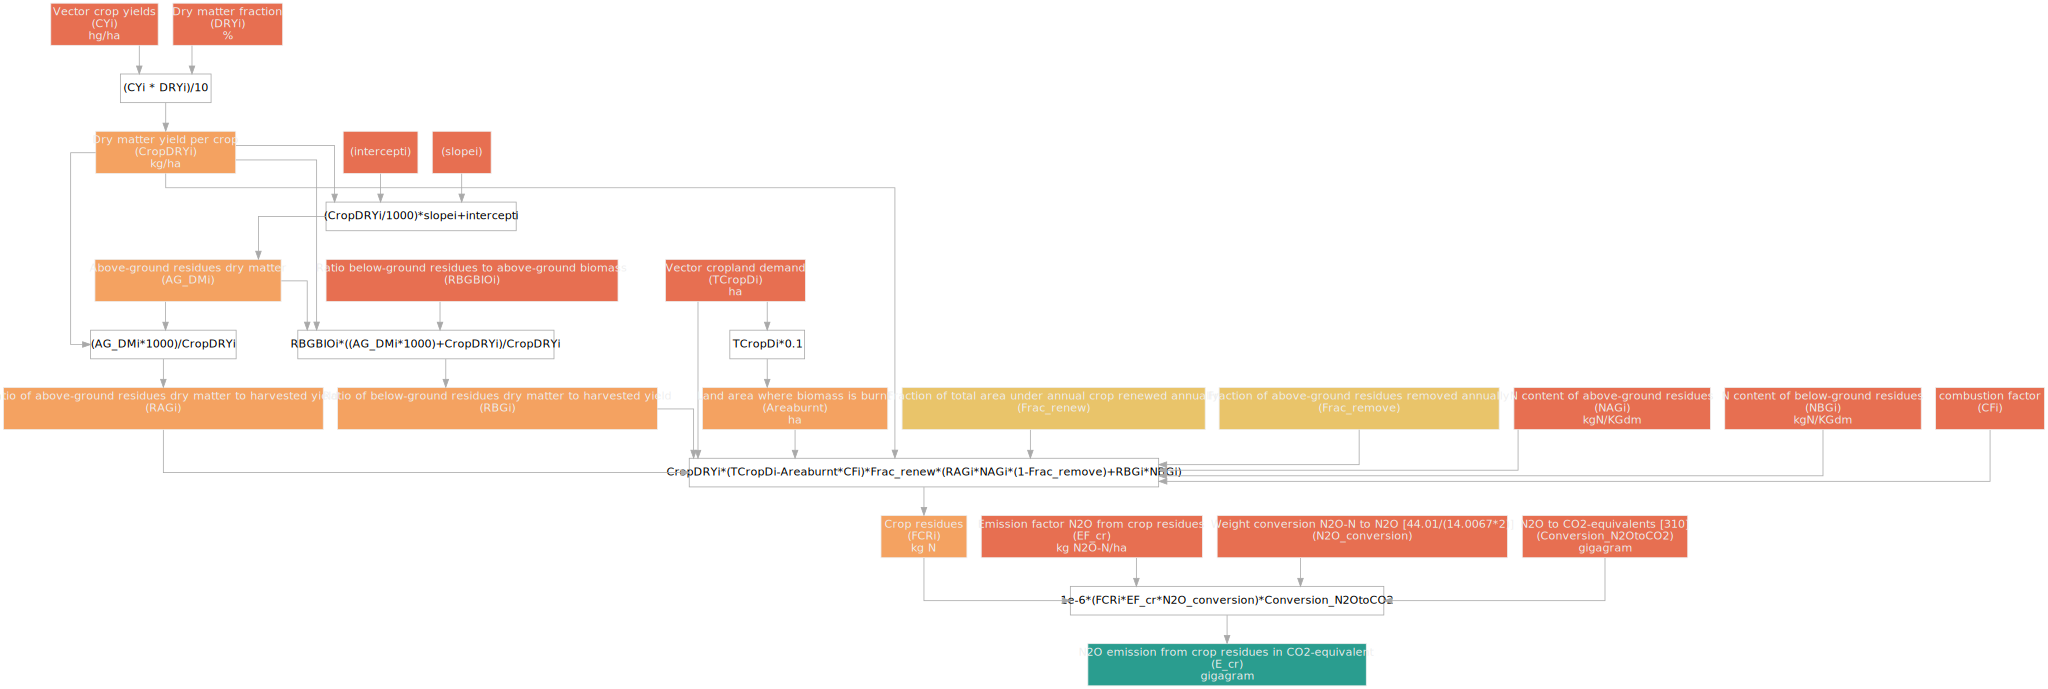

In [4]:
#CO2eq emissions from crop residues
#methodology / tables with parameters: http://www.fao.org/climatechange/41521-0373071b6020a176718f15891d3387559.pdf from table 45.
#only the following crops are assumed to have residue biomass:
Residue_crops = ['Barley', 'Beans, Dry', 'Maize','Millet','Oats','Potatoes','Rice, Paddy','Rye', 'Sorghum','Soybeans','Wheat']
#TCropDi[Residue_crops]
#FPi[Residue_crops]


residue_emissions = {
    'CYi': {'type': 'input',
             'unit': 'hg/ha',
             'name': 'Vector crop yields'},
    'DRYi': {'type': 'input',
              'unit': '%',
              'name': 'Dry matter fraction'},
    'CropDRYi': {'type': 'variable',
              'name': 'Dry matter yield per crop',
              'unit': 'kg/ha',
              'computation': lambda CYi, DRYi, **kwargs: (CYi * DRYi)/10
              },


    'slopei': {'type': 'input',
              'unit': '',
              'name': ''},
    'intercepti': {'type': 'input',
              'unit': '',
              'name': ''},
    'AG_DMi': {'type': 'variable',
              'name': 'Above-ground residues dry matter',
              'unit': '',
              'computation': lambda CropDRYi, slopei, intercepti, **kwargs: (CropDRYi/1000)*slopei+intercepti
              },

    'RAGi': {'type': 'variable',
              'name': 'Ratio of above-ground residues dry matter to harvested yield',
              'unit': '',
              'computation': lambda AG_DMi,CropDRYi, **kwargs: (AG_DMi*1000)/CropDRYi
              },


    'RBGBIOi': {'type': 'input',
              'unit': '',
              'name': 'Ratio below-ground residues to above-ground biomass'},
    'RBGi': {'type': 'variable',
              'name': 'Ratio of below-ground residues dry matter to harvested yield',
              'unit': '',
              'computation': lambda AG_DMi,RBGBIOi,CropDRYi, **kwargs: RBGBIOi*((AG_DMi*1000)+CropDRYi)/CropDRYi
              },

    'TCropDi': {'type': 'input',
              'unit': 'ha',
              'name': 'Vector cropland demand'},
    'Areaburnt': {'type': 'variable',
              'name': 'Land area where biomass is burnt',
              'unit': 'ha',
              'computation': lambda TCropDi, **kwargs: TCropDi*0.1
              },

    'Frac_renew': {'type': 'parameter',
              'unit': '',
              'name': 'Fraction of total area under annual crop renewed annually'},
    'Frac_remove': {'type': 'parameter',
              'unit': '',
              'name': 'Fraction of above-ground residues removed annually'},
    'NAGi': {'type': 'input',
              'unit': 'kgN/KGdm',
              'name': 'N content of above-ground residues'},
    'NBGi': {'type': 'input',
              'unit': 'kgN/KGdm',
              'name': 'N content of below-ground residues'},

    'CFi': {'type': 'input',
              'unit': '',
              'name': 'combustion factor'},

    'FCRi': {'type': 'variable',
              'name': 'Crop residues',
              'unit': 'kg N',
              'computation': lambda TCropDi,CropDRYi,CFi,NBGi,NAGi,RAGi,Frac_renew,Frac_remove,Areaburnt,RBGi, **kwargs: CropDRYi*(TCropDi-Areaburnt*CFi)*Frac_renew*(RAGi*NAGi*(1-Frac_remove)+RBGi*NBGi)
              },
    'EF_cr': {'type': 'input',
             'unit': 'kg N2O-N/ha',
             'name': 'Emission factor N2O from crop residues'},

    'N2O_conversion': {'type': 'input',
              'unit': '',
              'name': 'Weight conversion N2O-N to N2O [44.01/(14.0067*2)]'},

    'Conversion_N2OtoCO2': {'type': 'input',
              'unit': 'gigagram',
              'name': 'N2O to CO2-equivalents [310]'},

    'E_cr': {'type': 'output',
              'name': 'N2O emission from crop residues in CO2-equivalent',
              'unit': 'gigagram',
              'computation': lambda FCRi,EF_cr, N2O_conversion, Conversion_N2OtoCO2, **kwargs: 1e-6*(FCRi*EF_cr*N2O_conversion)*Conversion_N2OtoCO2
              },


}

barley = {
    'TCropDi': 268080,
    'CYi': 52834,
    'DRYi': 0.89,
    'slopei': 0.98,
    'intercepti': 0.59,
    'RBGBIOi': 0.22,
    'Frac_renew': 1,
    'Frac_remove': 0,
    'NAGi': 0.007,
    'NBGi': 0.014,
    'CFi': 0.8, 
    'EF_cr': 0.0123,
    'N2O_conversion': 1.571033862,
    'Conversion_N2OtoCO2': 310
  
}


Model = GraphModel(residue_emissions)

print(Model.run(barley))

Model.draw()

{'TCropDi_rice': 2765.2577259, 'EF_rice': 28, 'Conversion_CH4toCO2': 21, 'E_rice': 16.259715428292}


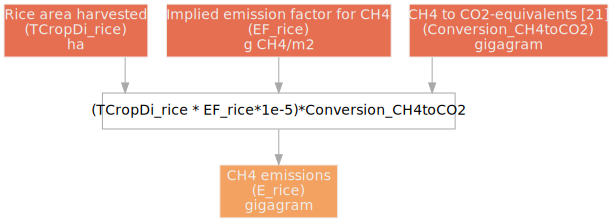

In [5]:
#CO2eq emissions from rice cultivation
#TCropDi_rice -> select rice from TCropDi vector



rice_emissions = {
    'TCropDi_rice': {'type': 'input',
             'unit': 'ha',
             'name': 'Rice area harvested'},
    'EF_rice': {'type': 'input',
              'unit': 'g CH4/m2',
              'name': 'Implied emission factor for CH4'},
    'E_rice': {'type': 'variable',
              'name': 'CH4 emissions',
              'unit': 'gigagram',
              'computation': lambda TCropDi_rice, EF_rice,Conversion_CH4toCO2, **kwargs: (TCropDi_rice * EF_rice*1e-5)*Conversion_CH4toCO2
              },


    'Conversion_CH4toCO2': {'type': 'input',
              'unit': 'gigagram',
              'name': 'CH4 to CO2-equivalents [21]'},


             
}

rice = {
    'TCropDi_rice': 2765.2577259,
    'EF_rice': 28,
    'Conversion_CH4toCO2': 21,


}


Model = GraphModel(rice_emissions)

print(Model.run(rice))

Model.draw()





{'Frac_burn': 0.1, 'TCropDi_burn': 988817.384159404, 'FUEL': 10, 'EF_N2Oburn': 0.0001, 'EF_CH4burn': 2.7, 'Conversion_CH4toCO2': 21, 'Conversion_N2OtoCO2': 310, 'N2O_conversion': 1.5710339, 'TAB': 98881.7384159404, 'BMB': 988817.3841594041, 'E_burn_CH4': 2.6698069372303914, 'E_burn_N2O': 0.06294055043366055, 'E_burn': 75.57751631627299}


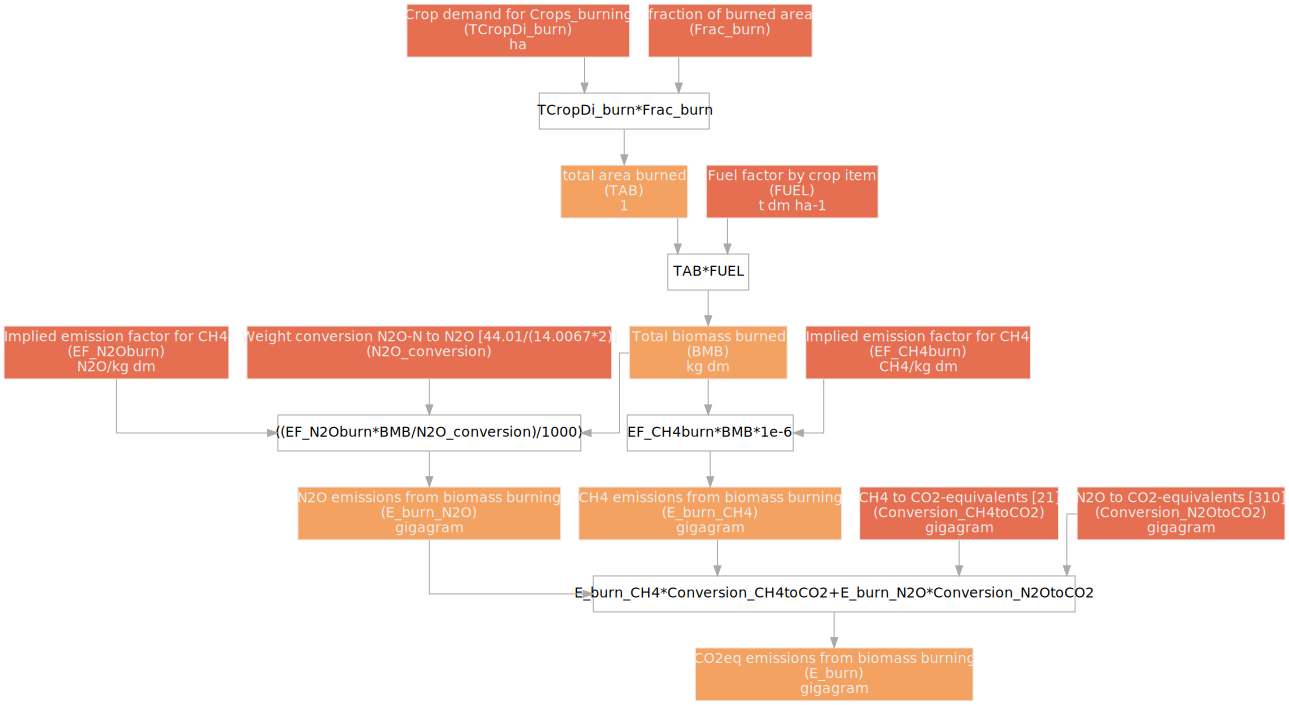

In [6]:
#CO2eq emissions from burning biomass/crop residues
#http://www.fao.org/faostat/en/#data/GB

Crops_burning = ['Wheat','Maize','Rice','Sugarcane']

emissions_burning = {
    'TCropDi_burn': {'type': 'input',
             'unit': 'ha',
             'name': 'Crop demand for Crops_burning'},
    'Frac_burn': {'type': 'input',
              'unit': '',
              'name': 'fraction of burned area'},
    'TAB': {'type': 'variable',
              'name': 'total area burned',
              'unit': '1',
              'computation': lambda TCropDi_burn, Frac_burn, **kwargs: TCropDi_burn*Frac_burn
              },
    'FUEL': {'type': 'input',
              'unit': 't dm ha-1',
              'name': 'Fuel factor by crop item'},

    'BMB': {'type': 'variable',
              'name': 'Total biomass burned',
              'unit': 'kg dm',
              'computation': lambda TAB, FUEL, **kwargs: TAB*FUEL
              },

    'EF_N2Oburn': {'type': 'input',
              'unit': 'N2O/kg dm',
              'name': 'Implied emission factor for CH4'},

    'EF_CH4burn': {'type': 'input',
              'unit': 'CH4/kg dm',
              'name': 'Implied emission factor for CH4'},

    'Conversion_CH4toCO2': {'type': 'input',
              'unit': 'gigagram',
              'name': 'CH4 to CO2-equivalents [21]'},

    'Conversion_N2OtoCO2': {'type': 'input',
              'unit': 'gigagram',
              'name': 'N2O to CO2-equivalents [310]'},  
              
    'N2O_conversion': {'type': 'input',
              'unit': '',
              'name': 'Weight conversion N2O-N to N2O [44.01/(14.0067*2)]'},

    'E_burn_N2O': {'type': 'variable',
              'name': 'N2O emissions from biomass burning',
              'unit': 'gigagram',
              'computation': lambda BMB,EF_N2Oburn,N2O_conversion, **kwargs: ((EF_N2Oburn*BMB/N2O_conversion)/1000)
              },                          

    'E_burn_CH4': {'type': 'variable',
              'name': 'CH4 emissions from biomass burning',
              'unit': 'gigagram',
              'computation': lambda BMB,EF_CH4burn, **kwargs: EF_CH4burn*BMB*1e-6
              }, 
              
    'E_burn': {'type': 'variable',
              'name': 'CO2eq emissions from biomass burning',
              'unit': 'gigagram',
              'computation': lambda E_burn_CH4,E_burn_N2O,Conversion_N2OtoCO2,Conversion_CH4toCO2, **kwargs: E_burn_CH4*Conversion_CH4toCO2+E_burn_N2O*Conversion_N2OtoCO2
              }, 



}

burn_maize = {
    'Frac_burn': 0.1,
    'TCropDi_burn': 988817.384159404,
    'FUEL': 10,
    'EF_N2Oburn': 0.0001,
    'EF_CH4burn': 2.7,
    'Conversion_CH4toCO2': 21,
    'Conversion_N2OtoCO2':310,
    'N2O_conversion': 1.5710339

}


Model = GraphModel(emissions_burning)

print(Model.run(burn_maize))

Model.draw()




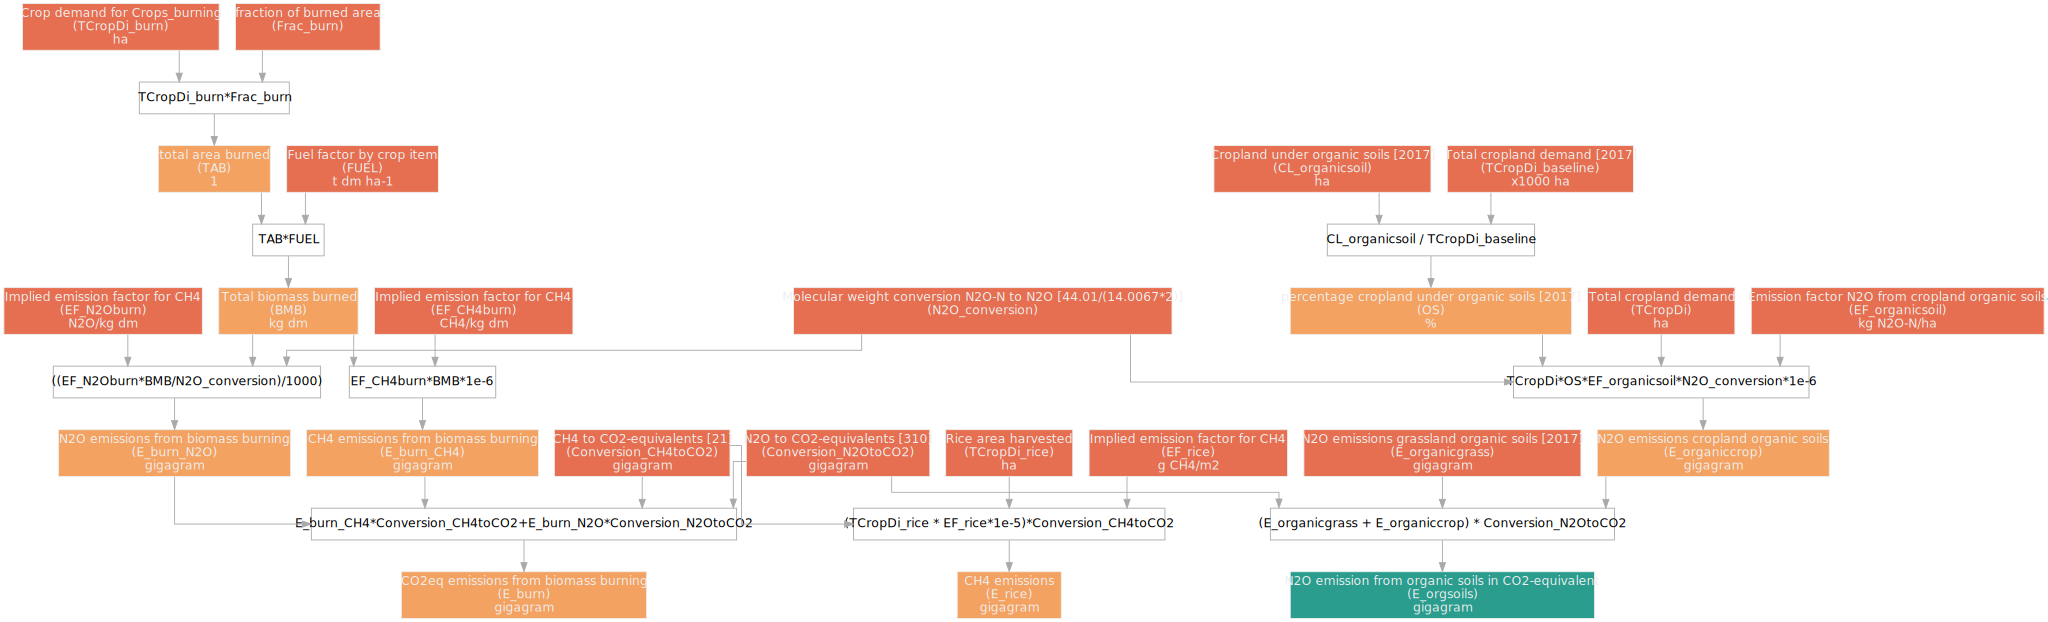

In [7]:
merge_models([
    GraphModel(emissions_burning),
    GraphModel(rice_emissions),
    GraphModel(Emissions_organic_soils)
]).draw()

# Refactored model

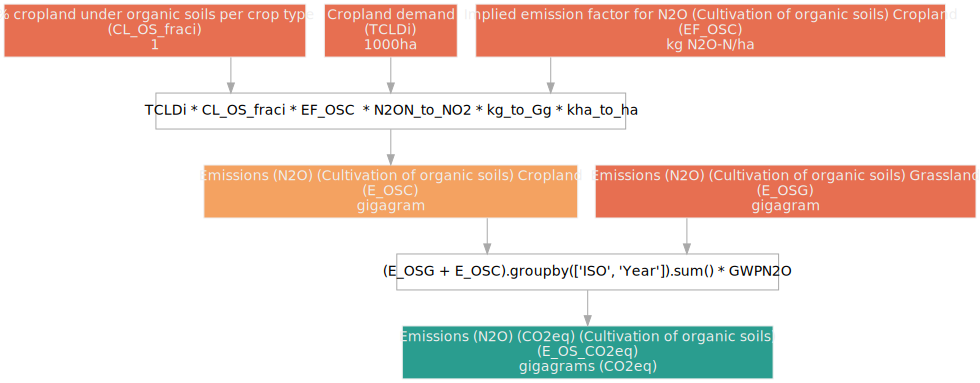

In [18]:
#CO2eq emissions from the cultivation of organic soils
#dataset cultivation of organic soils: http://www.fao.org/faostat/en/#data/GV 
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3


Emissions_organic_soils = {

    'CL_OS_fraci': {'type': 'input', # to be precomupted in the database
              'name': '% cropland under organic soils per crop type',
              'unit': '1',
              },

    'E_OSG': {'type': 'input',
              'unit': 'gigagram',
              'name': 'Emissions (N2O) (Cultivation of organic soils) Grassland'},

    'E_OS_CO2eq': {'type': 'output',
              'name': 'Emissions (N2O) (CO2eq) (Cultivation of organic soils)',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda E_OSG, E_OSC, **kwargs: (E_OSG + E_OSC).groupby(['ISO', 'Year']).sum() * GWPN2O
              },
    'TCLDi': {'type': 'input',
             'unit': '1000ha',
             'name': 'Cropland demand'},
    'EF_OSC': {'type': 'input',
             'unit': 'kg N2O-N/ha',
             'name': 'Implied emission factor for N2O (Cultivation of organic soils) Cropland'},
    'E_OSC': {'type': 'variable',
              'name': 'Emissions (N2O) (Cultivation of organic soils) Cropland',
              'unit': 'gigagram',
              'computation': lambda CL_OS_fraci,TCLDi, EF_OSC, **kwargs:  TCLDi * CL_OS_fraci * EF_OSC  * N2ON_to_NO2 * kg_to_Gg * kha_to_ha
             } 
}


E_OS_model = GraphModel(Emissions_organic_soils)

E_OS_model.draw()

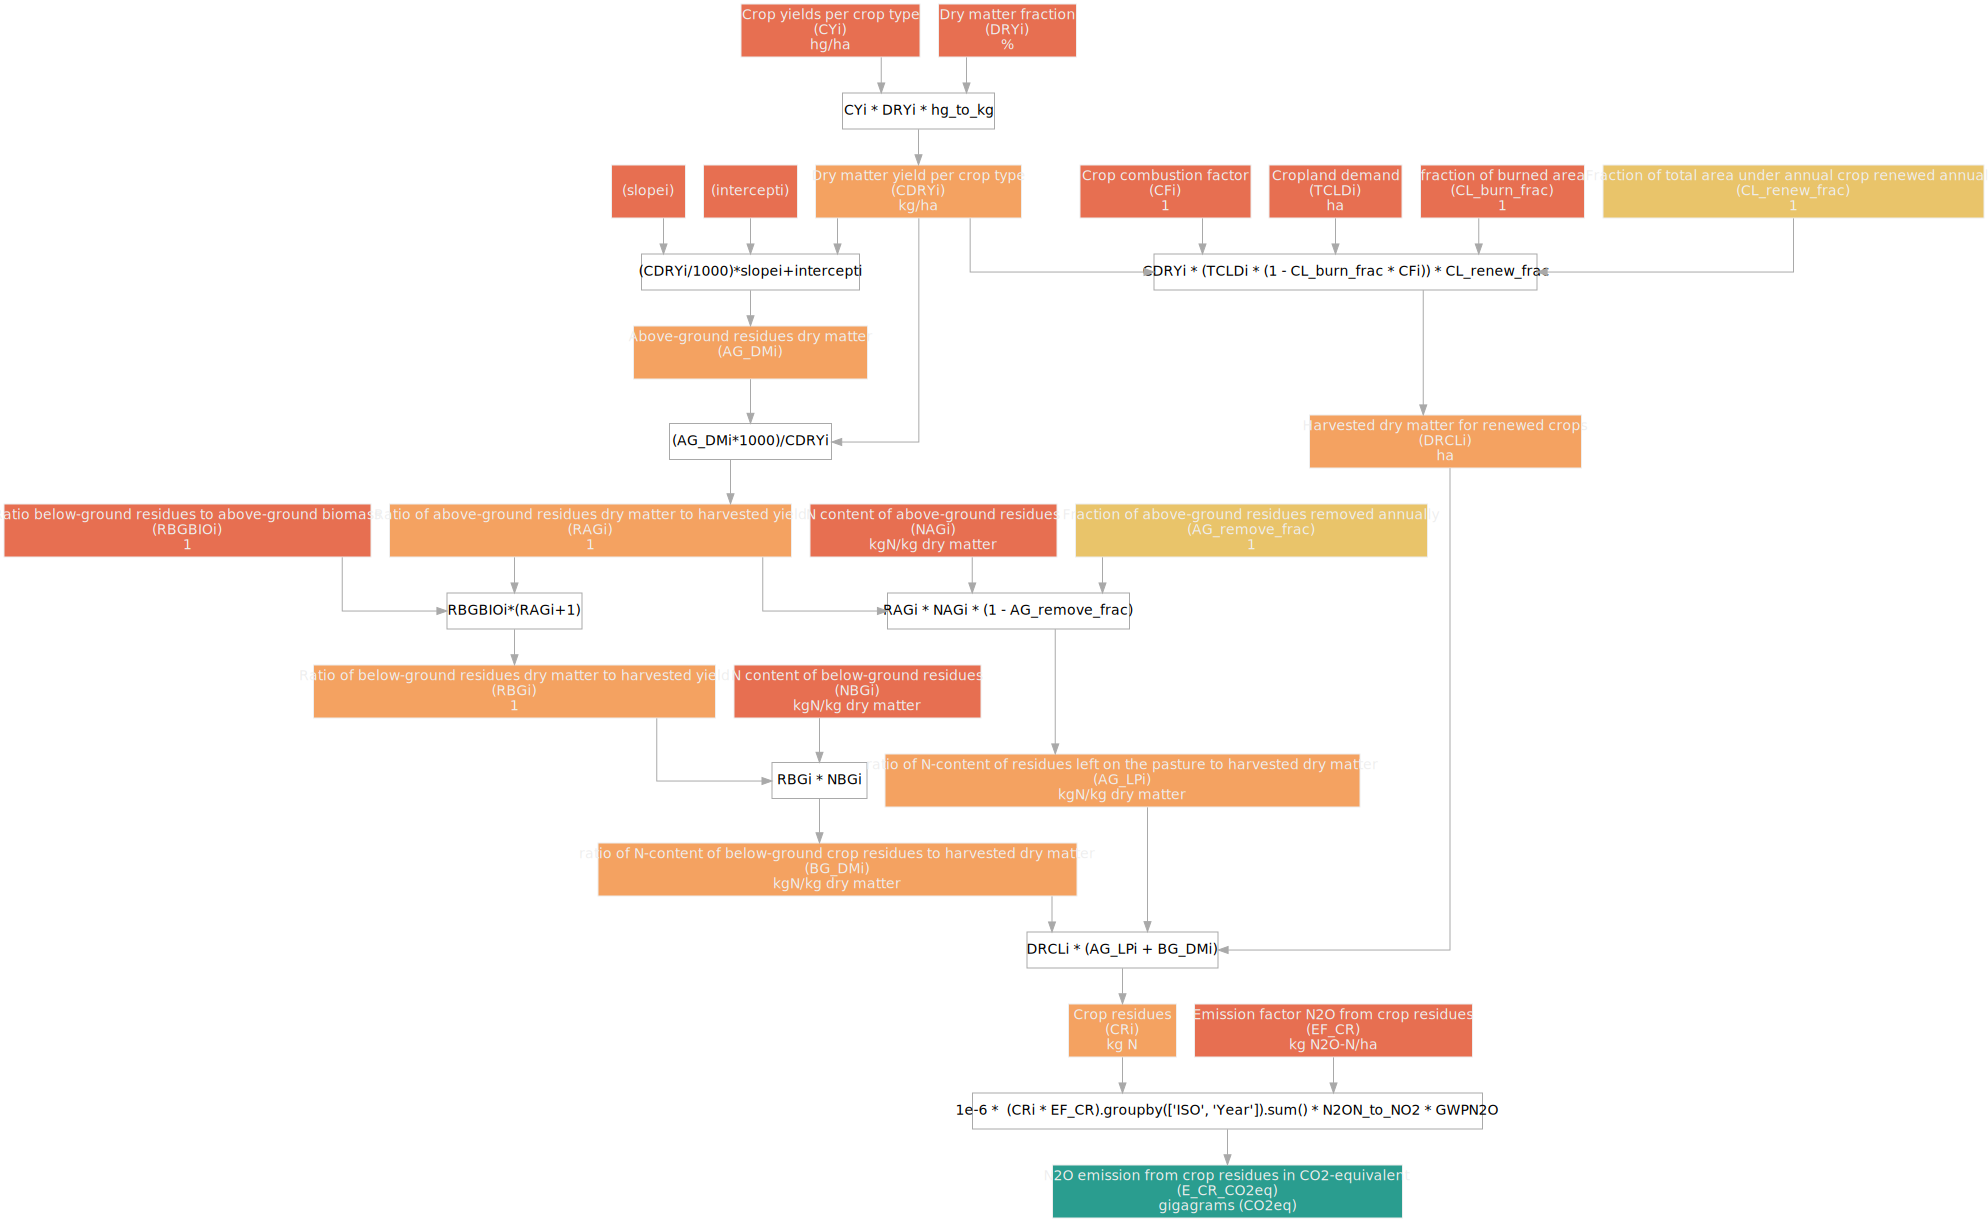

In [19]:

#CO2eq emissions from crop residues
#methodology / tables with parameters: http://www.fao.org/climatechange/41521-0373071b6020a176718f15891d3387559.pdf from table 45.
#only the following crops are assumed to have residue biomass:
Residue_crops = ['Barley', 'Beans, Dry', 'Maize','Millet','Oats','Potatoes','Rice, Paddy','Rye', 'Sorghum','Soybeans','Wheat']
#TCropDi[Residue_crops]
#FPi[Residue_crops]


hg_to_kg = 1e-1
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3
GWPCH4 = 21
tonnes_to_kg = 1e3
g_to_Gg = 1e-9


residue_emissions = {
    'CYi': {'type': 'input',
             'unit': 'hg/ha',
             'name': 'Crop yields per crop type'},
    'DRYi': {'type': 'input',
              'unit': '%',
              'name': 'Dry matter fraction'},
    'CDRYi': {'type': 'variable',
              'name': 'Dry matter yield per crop type',
              'unit': 'kg/ha',
              'computation': lambda CYi, DRYi, **kwargs: CYi * DRYi * hg_to_kg
              },
    'slopei': {'type': 'input',
              'unit': '',
              'name': ''},
    'intercepti': {'type': 'input',
              'unit': '',
              'name': ''},
    'AG_DMi': {'type': 'variable',
              'name': 'Above-ground residues dry matter',
              'unit': '',
              'computation': lambda CDRYi, slopei, intercepti, **kwargs: (CDRYi/1000)*slopei+intercepti
              },
    'RAGi': {'type': 'variable',
              'name': 'Ratio of above-ground residues dry matter to harvested yield',
              'unit': '1',
              'computation': lambda AG_DMi,CDRYi, **kwargs: (AG_DMi*1000)/CDRYi
              },
    'RBGBIOi': {'type': 'input',
              'unit': '1',
              'name': 'Ratio below-ground residues to above-ground biomass'},
    'RBGi': {'type': 'variable',
              'name': 'Ratio of below-ground residues dry matter to harvested yield',
              'unit': '1',
              'computation': lambda RAGi,RBGBIOi, **kwargs: RBGBIOi*(RAGi+1)
              },
    'TCLDi': {'type': 'input',
              'unit': 'ha',
              'name': 'Cropland demand'}, # add selection of crops
    'CL_burn_frac': {'type': 'input',
                     'unit': '1',
                     'name': 'fraction of burned area'},
    'CL_renew_frac': {'type': 'parameter',
              'unit': '1',
              'name': 'Fraction of total area under annual crop renewed annually'},
    'AG_remove_frac': {'type': 'parameter',
              'unit': '1',
              'name': 'Fraction of above-ground residues removed annually'},
    'NAGi': {'type': 'input',
              'unit': 'kgN/kg dry matter',
              'name': 'N content of above-ground residues'},
    'NBGi': {'type': 'input',
              'unit': 'kgN/kg dry matter',
              'name': 'N content of below-ground residues'},

    'CFi': {'type': 'input',
              'unit': '1',
              'name': 'Crop combustion factor'},
    
   'DRCLi': {'type': 'variable',
              'name': 'Harvested dry matter for renewed crops',
              'unit': 'ha',
              'computation': lambda TCLDi,CDRYi,CFi,CL_renew_frac, CL_burn_frac, **kwargs: CDRYi * (TCLDi * (1 - CL_burn_frac * CFi)) * CL_renew_frac
              },
   'AG_LPi': {'type': 'variable',
              'name': 'ratio of N-content of residues left on the pasture to harvested dry matter',
              'unit': 'kgN/kg dry matter',
              'computation': lambda RAGi, NAGi, AG_remove_frac, **kwargs: RAGi * NAGi * (1 - AG_remove_frac)
              },
   'BG_DMi': {'type': 'variable',
              'name': 'ratio of N-content of below-ground crop residues to harvested dry matter',
              'unit': 'kgN/kg dry matter',
              'computation': lambda RBGi, NBGi, **kwargs: RBGi * NBGi
               },
    'CRi': {'type': 'variable',
              'name': 'Crop residues',
              'unit': 'kg N',
              'computation': lambda DRCLi, AG_LPi, BG_DMi, **kwargs: DRCLi * (AG_LPi + BG_DMi)
              },
#     'CRi': {'type': 'variable',
#               'name': 'Crop residues',
#               'unit': 'kg N',
#               'computation': lambda TCLDi,CDRYi,CFi,NBGi,NAGi,RAGi,CL_renew_frac,AG_remove_frac, CL_burn_frac, RBGi, **kwargs: CDRYi * (TCLDi * (1 - CL_burn_frac * CFi)) * CL_renew_frac * (RAGi * NAGi * (1 - AG_remove_frac) + RBGi * NBGi)
#               },
    'EF_CR': {'type': 'input',
             'unit': 'kg N2O-N/ha',
             'name': 'Emission factor N2O from crop residues'},
    'E_CR_CO2eq': {'type': 'output',
              'name': 'N2O emission from crop residues in CO2-equivalent',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda CRi, EF_CR, **kwargs: 1e-6 *  (CRi * EF_CR).groupby(['ISO', 'Year']).sum() * N2ON_to_NO2 * GWPN2O
              },
}


E_CR_model = GraphModel(residue_emissions)

E_CR_model.draw()

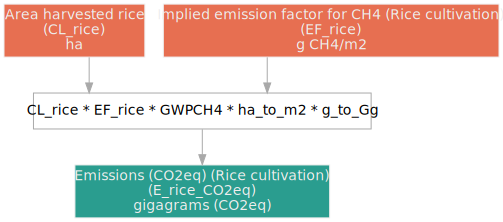

In [20]:
GWPCH4 = 21
g_to_Gg = 1e-6
ha_to_m2 = 1e5

rice_emissions = {
    'CL_rice': {'type': 'input',
             'unit': 'ha',
             'name': 'Area harvested rice'},
    'EF_rice': {'type': 'input',
              'unit': 'g CH4/m2',
              'name': 'Implied emission factor for CH4 (Rice cultivation)'},
    'E_rice_CO2eq': {'type': 'output',
              'name': 'Emissions (CO2eq) (Rice cultivation)',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda CL_rice, EF_rice, **kwargs: CL_rice * EF_rice * GWPCH4 * ha_to_m2 * g_to_Gg
              },
}


E_rice_model = GraphModel(rice_emissions)


E_rice_model.draw()

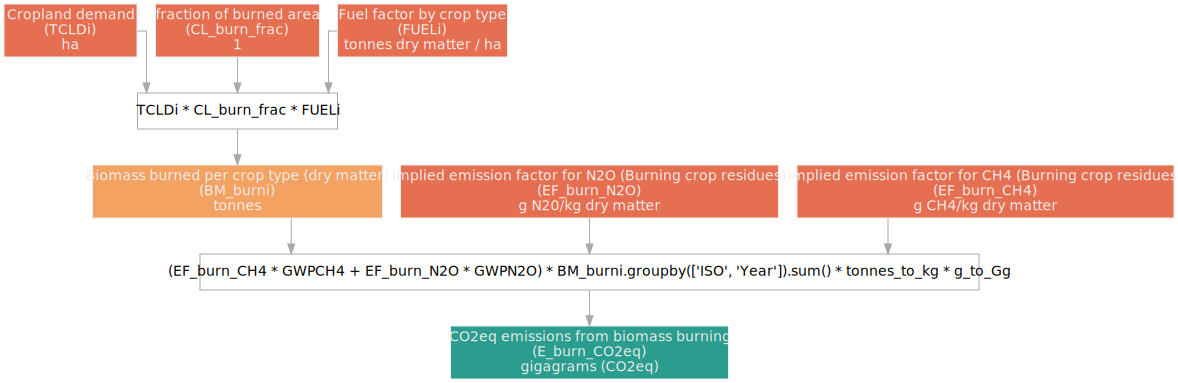

In [21]:
#CO2eq emissions from burning biomass/crop residues
#http://www.fao.org/faostat/en/#data/GB
GWPN2O = 310
N2ON_to_NO2 = 1.57
kg_to_Gg = 1e-6
kha_to_ha = 1e-3
GWPCH4 = 21
tonnes_to_kg = 1e3
g_to_Gg = 1e-9

Crops_burning = ['Wheat','Maize','Rice','Sugarcane']

emissions_burning = {
    'TCLDi': {'type': 'input',
                  'unit': 'ha',
                  'name': 'Cropland demand'}, # add selection of crops
    'CL_burn_frac': {'type': 'input',
                     'unit': '1',
                     'name': 'fraction of burned area'},

    'FUELi': {'type': 'input',
              'unit': 'tonnes dry matter / ha',
              'name': 'Fuel factor by crop type'},

    'BM_burni': {'type': 'variable',
              'name': 'Biomass burned per crop type (dry matter)',
              'unit': 'tonnes',
              'computation': lambda TCLDi, CL_burn_frac, FUELi, **kwargs: TCLDi * CL_burn_frac * FUELi
              },

    'EF_burn_N2O': {'type': 'input',
              'unit': 'g N20/kg dry matter',
              'name': 'Implied emission factor for N2O (Burning crop residues)'},

    'EF_burn_CH4': {'type': 'input',
              'unit': 'g CH4/kg dry matter',
              'name': 'Implied emission factor for CH4 (Burning crop residues)'},
              
    'E_burn_CO2eq': {'type': 'output',
              'name': 'CO2eq emissions from biomass burning',
              'unit': 'gigagrams (CO2eq)',
              'computation': lambda EF_burn_N2O, EF_burn_CH4, BM_burni, **kwargs: (EF_burn_CH4 * GWPCH4 + EF_burn_N2O * GWPN2O) * BM_burni.groupby(['ISO', 'Year']).sum() * tonnes_to_kg * g_to_Gg
              }, 

}


E_burn_model = GraphModel(emissions_burning)

E_burn_model.draw()

In [24]:
OE_nodes = {
                  
    'E_burn_CO2eq': {'type': 'input',
              'name': 'CO2eq emissions from biomass burning',
              'unit': 'gigagrams (CO2eq)',
              }, 
    'E_rice_CO2eq': {'type': 'input',
              'name': 'Emissions (CO2eq) (Rice cultivation)',
              'unit': 'gigagrams (CO2eq)',
              },
    'E_CR_CO2eq': {'type': 'input',
          'name': 'N2O emission from crop residues in CO2-equivalent',
          'unit': 'gigagrams (CO2eq)',
          },
    
    'E_OS_CO2eq': {'type': 'input',
              'name': 'Emissions (N2O) (CO2eq) (Cultivation of organic soils)',
              'unit': 'gigagrams (CO2eq)',
              },   
    'OE_CO2eq':{
        'type': 'output',
        'name': 'Emissions other',
        'unit': 'gigagrams (CO2eq)',
        'computation': lambda E_burn_CO2eq, E_rice_CO2eq, E_CR_CO2eq, E_OS_CO2eq, **kwargs: E_rice_CO2eq + E_burn_CO2eq + E_CR_CO2eq + E_OS_CO2eq
    }
    
}

E_other_model = GraphModel(OE_nodes)

In [25]:
merge_models([E_other_model, E_burn_model, E_rice_model, E_CR_model, E_OS_model]).draw().render('Emission')

'Emission.pdf'